# Localization

In [780]:
import numpy as np
from spatialmath.base import skew, qeye, tr2angvec, q2r, qangle, qnorm, qqmul, qconj
from spatialmath import UnitQuaternion as UQ
import matplotlib.pyplot as plt
import mujoco as mj
import mujoco.viewer
import os
import time

# Problem 1

In [781]:
#define function that takes current quaternion, angular velocity, and timestep to produce an estimated quaternion
def fw_step(q_curr, ang_vel, t_step): #ang_vel must be shape (1, 3) and q_curr must be shape (1, 4)
    if ang_vel.shape != (1, 3):
        raise ValueError(f"Expected angular velocity shape (1, 3), got {ang_vel.shape}")
    if q_curr.shape != (1, 4):
        raise ValueError(f"Expected input quaternion shape (1, 4), got {q_curr.shape}")

    #construct the omega Matrix
    omegaM = np.block([
    [0                     ,                 -ang_vel],
    [ang_vel.reshape(3, -1),           -skew(ang_vel)]
    ])

    #compute closed form exponential
    ang_vel_norm = np.linalg.norm(ang_vel)
    e = (np.cos(ang_vel_norm*0.5*t_step) * np.eye(4,4)) + (np.sin(ang_vel_norm*0.5*t_step) * (omegaM/ang_vel_norm))
    
    #construct updated quaternion
    q_update = e @ q_curr.reshape(4,-1)
   
    return q_update.reshape(-1,4)


timestep = 0.25 #1/4 second
omega_x = np.array([[np.pi, 0, 0]])
omega_z = np. array([[0, 0, np.pi]])
q_initial = np.array([UQ()])

#Rotate about the body x-axis for 1/4 s at π rad/s.
q_1 = fw_step(q_initial, omega_x, timestep)
print("Estimated quaternion after first step: ", q_1)

#Rotate about the body z-axis for 1/4 s at π rad/s
q_2 = fw_step(q_1, omega_z, timestep)
print("Estimated quaternion after second step: ", q_2)

#Rotate about the body x-axis for 1/4 s at −π rad/s
q_3 = fw_step(q_2, -omega_x, timestep)
print("Estimated quaternion after third step: ", q_3)

#Rotate about the body z-axis for 1/4 s at −π rad/s
q_4 = fw_step(q_3, -omega_z, timestep)
print("Estimated quaternion after fourth step: ", q_4)

Estimated quaternion after first step:  [[0.92387953 0.38268343 0.         0.        ]]
Estimated quaternion after second step:  [[ 0.85355339  0.35355339 -0.14644661  0.35355339]]
Estimated quaternion after third step:  [[ 0.92387953  0.         -0.27059805  0.27059805]]
Estimated quaternion after fourth step:  [[ 0.95710678  0.10355339 -0.25       -0.10355339]]


 Q1) Report the rotation q(1) at the end of this motion, i.e., after 1s has elapsed. Does it hold that q(1) = q(0)? Discuss why this is true or false.

 q(1) != q(0) for two potential reasons:
 1. In order to get back to intial orientation the rotation backwards through the z-axis would have to come first. Doing a rotation xzxz is not the same as doing xzzx
 2. 0.25 second time step is a large amount of time for our linearization assumption. t_step should be sufficiently small to properly linearize our integration.

# Problem 2

[ 9.99874756e-01 -3.15840461e-04  4.81192838e-04 -1.58158519e-02]
Total rotation:  105.02485597967491


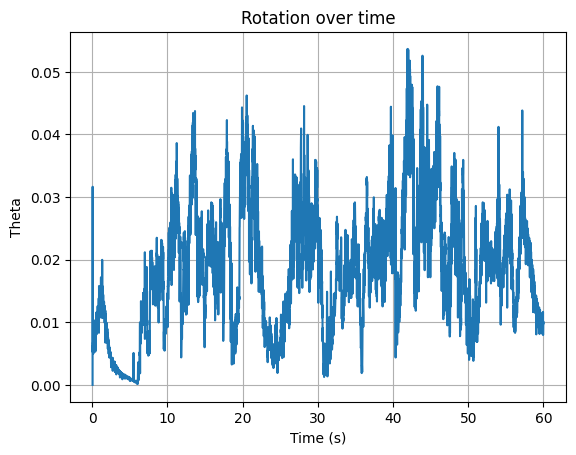

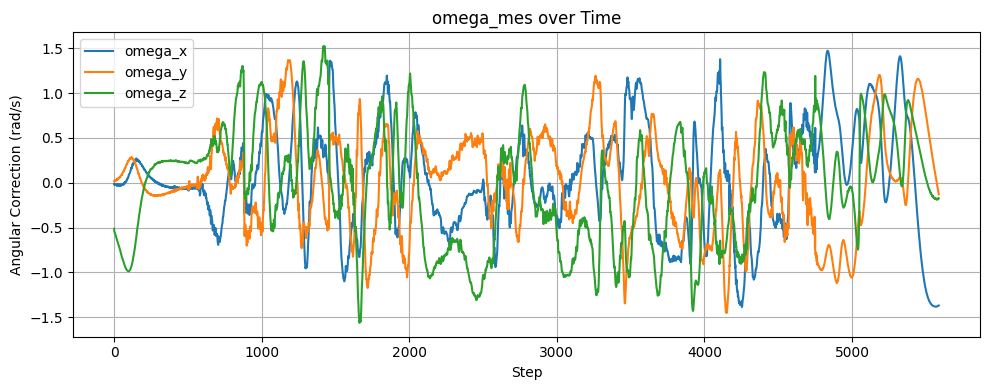

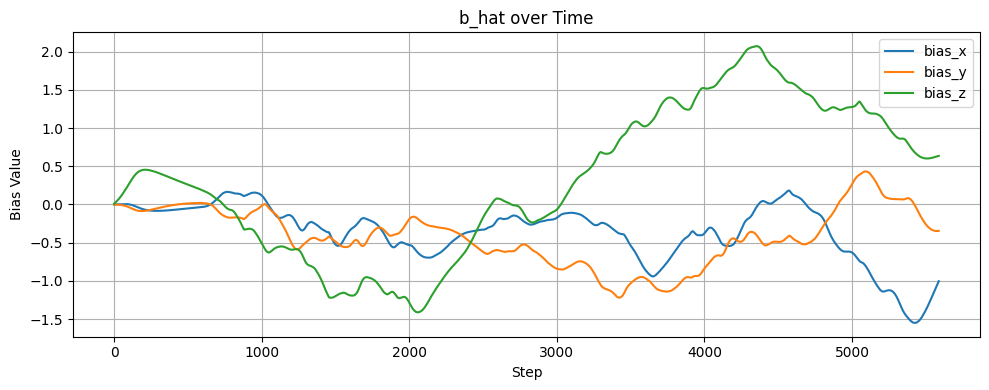

In [782]:
# Pull data from input file and store in data
data = []
num_lines = 0
with open("input", "r") as file:
    for line in file:
        row = [float(x.strip()) for x in line.strip().split(",")] #for every line in the input file, remove the newline tag, split at the commas, and remove extra spaces before storing.
        data.append(row)
        num_lines += 1

data = np.array(data)

# Actual acceleration construction from input file
# Actual magnetic north construction from input file
# Actual velocity construction
def get_values(value, step):
    if value == "m":
        values = data[step,[1, 2, 3]]
        values = values/np.linalg.norm(values)
        return np.array([values])
    elif value == "v":
        values = data[step,[4, 5, 6]]
        return np.array([values])
    elif value == "a":
        values = data[step,[7, 8, 9]]
        values = values/np.linalg.norm(values)
        return np.array([values])
    elif value == "t":
        values = data[step,[0]]
        return values



# Estimated acceleration contruction
# Estimated magnetic north construction
# Estimated bias vector construction



#constant assigns
k_p = 1.0 #proportional gain constant
k_i = 0.3 #integral gain constant
k_a = 1.0 #acceleration constant
k_m = 1.0 #magnetic north constant

g_ref = np.array([[0, 0, 1]])
m_ref = np.array([[1, 0, 0]])

dt = 0.01

#computing one step
q = np.array([UQ()])
q_array = np.zeros((num_lines + 1, 4))
b_hat = np.array([np.zeros(3)])
q_array[0] = q

time_array = np.zeros((num_lines))
dt = np.zeros((num_lines))
omega_mes_array = np.zeros((num_lines, 3))
b_hat_array = np.zeros((num_lines, 3))

for i, row in enumerate(time_array):
    time_array[i] = get_values("t", i)[0]
    if i==0:
        dt[i] = time_array[i]
    else:
        dt[i] = time_array[i] - time_array[i-1]


     

for i, row in enumerate(data):
    q = UQ(q)
    # pull magnetometer values
    mvalues = get_values("m", i)

    # pull accelerometer values
    avalues = get_values("a", i)

    # pull angular velocity values
    vvalues = get_values("v", i)

    # mag correction to only adjust YAW
    mag_inertial = (q.R @ mvalues.reshape(3,-1)).reshape(-1,3)          # magnetometer values moved to current world frame
    mag_z = (np.dot(mag_inertial, g_ref[0]) * g_ref[0]).reshape(-1,3)   # project onto gravitational direction
    mag_xy = mag_inertial - mag_z                                       # isolate xy plane
    mag_xy /= np.linalg.norm(mag_xy)                                    # normalize
    

    m_values = (np.array(q.R).T @ mag_xy.reshape(3,-1)).reshape(-1,3)


    v_a = (np.array(q.R) @ g_ref.reshape(3,-1)).reshape(-1,3)
    v_m = (np.array(q.R) @ m_ref.reshape(3,-1)).reshape(-1,3)
    
    u = vvalues - b_hat

    u_mag = np.linalg.norm(u)
    u_x = skew(u)

    if u_mag < 1e-6:
        expM_u = np.eye(3)
    else:
        expM_u = np.eye(3) + (np.sin(-u_mag * dt[i]) * (u_x / u_mag)) + ((1 - np.cos(-u_mag * dt[i])) * ((u_x @ u_x) / (u_mag**2)))
   
    v_m_hat = (expM_u @ v_m.reshape(3,-1)).reshape(-1,3)
    v_a_hat = (expM_u @ v_a.reshape(3,-1)).reshape(-1,3)


    omega_mes = k_a * np.cross(avalues, v_a_hat) + k_m * np.cross(m_values, v_m_hat)

    b_hat_dot = k_i * omega_mes
    b_hat -= b_hat_dot * dt[i]

    u = vvalues - b_hat + (k_p * omega_mes)

    omega_mes_array[i] = omega_mes
    b_hat_array[i] = b_hat

    q = fw_step(np.array(q).reshape(-1,4), u, dt[i])
    q /= np.linalg.norm(q)

    q_array[i+1] = q



angel_vec_array = np.zeros((num_lines))

print(qqmul(q_array[1], qconj(q_array[0])))

for i, row in enumerate(time_array):
    
    if i == 0:
        angel_vec_array[i] = 0
    else:
        angel_vec_array[i] = tr2angvec(q2r(qqmul(q_array[i], qconj(q_array[i-1]))))[0]      # Calculates relative rotation between 2 quaternions and converst to angle vector form to extract the rotation
    #angel_vec_array[i] = qangle(q_array[i], q_array[i+1])                   # extract the realtive rotations between the two quaternions: rotation from 1->2 etc.



total_theta = sum(angel_vec_array)
print("Total rotation: ", total_theta)
#
fig, theta_p2 = plt.subplots()
theta_p2.plot(time_array, angel_vec_array)
theta_p2.set(xlabel='Time (s)', ylabel='Theta',
       title='Rotation over time')
theta_p2.grid()

fig.savefig("theta_problem2.png")


plt.figure(figsize=(10, 4))
plt.plot(omega_mes_array[:, 0], label='omega_x')
plt.plot(omega_mes_array[:, 1], label='omega_y')
plt.plot(omega_mes_array[:, 2], label='omega_z')
plt.title("omega_mes over Time")
plt.xlabel("Step")
plt.ylabel("Angular Correction (rad/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
    
plt.figure(figsize=(10, 4))
plt.plot(b_hat_array[:, 0], label='bias_x')
plt.plot(b_hat_array[:, 1], label='bias_y')
plt.plot(b_hat_array[:, 2], label='bias_z')
plt.title("b_hat over Time")
plt.xlabel("Step")
plt.ylabel("Bias Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Mujoco visualization

comment out/in "run = True" to not run or run the visualization

In [783]:
run = False
#run = True

filename = "Phone.xml"  # xml file
file_path = os.path.join(os.getcwd(), filename)

model = mj.MjModel.from_xml_path(file_path)

#Load the data
modeldata = mj.MjData(model)


sim_time = 100.0 #100 second simulation time
start_time = time.time()

body_name = "body1"
body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, body_name)

joint_id = model.body_jntadr[body_id]
qpos_addr = model.jnt_qposadr[joint_id]

position = np.array([0.0, 0.0, 1.0]) # x,y,z


if run == True:
    count = 0
    with mujoco.viewer.launch_passive(model, modeldata) as viewer:
        time.sleep(5)
        while ((time.time() - start_time) < sim_time):
            
            step_start = time.time()
            
            
            modeldata.qpos[qpos_addr : qpos_addr + 3] = position

            modeldata.qpos[qpos_addr + 3 : qpos_addr + 7] = q_array[count]

            mujoco.mj_forward(model, modeldata)

            count += 1
            if count == 5590:
                break
            time_until_next_step = 0.01 - (time.time() - step_start) #this limits the while loop to only run every 0.01seconds
            viewer.sync()
            if time_until_next_step > 0:
                time.sleep(time_until_next_step)

# Problem 3

# Problem 4